# 타깃값으로 군집 평가

* ARI와 NMI 가 있음
> 0: 무작위로 분류됬을때와 비슷한 성능인 경우<br>1: 분류가 모두 올바르게 된 경우
* ARI은 점수가 음수일 수 있음 (무작위보다도 성능이 낮은 경우)

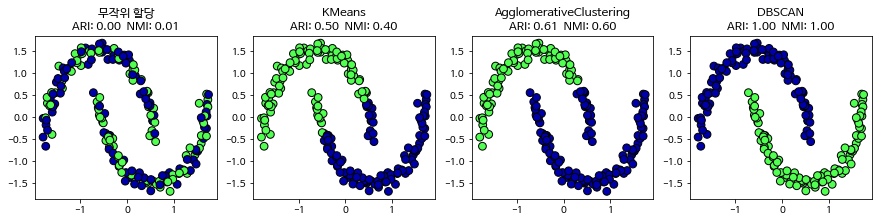

In [1]:
from ml1.preamble import*
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
X_scaled = StandardScaler().fit_transform(X)

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
models = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

rand_state= np.random.RandomState(seed=0)
rand_clusters = rand_state.randint(low=0, high=2, size=len(X))

fig, axes = plt.subplots(1, 4, figsize=(15,3))
axes[0].scatter(X_scaled[:,0], X_scaled[:,1], c=rand_clusters, cmap=mglearn.cm3, s=60, edgecolors='k')
axes[0].set_title('무작위 할당\n'+
 f'ARI: {adjusted_rand_score(y, rand_clusters):.2f}  NMI: {normalized_mutual_info_score(y, rand_clusters):.2f}')

for ax, model in zip(axes[1:], models):
    clusters = model.fit_predict(X_scaled)
    ax.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters, cmap=mglearn.cm3, s=60, edgecolors='k')
    ax.set_title(f'{model.__class__.__name__}\n'+
        f'ARI: {adjusted_rand_score(y, clusters):.2f}  NMI: {normalized_mutual_info_score(y, clusters):.2f}')

=> sklearn.metric의 accuracy_score를 쓸 경우 올바르게 분류해도 군집별 레이블값이 다를 수 있기 때문에 쓰면 안됨

# 타깃값 없이 군집 평가

* silhouette coefficient는 클러스터의 밀집 정도를 계산 (최대 1)
* 원형일수록 점수가 높음

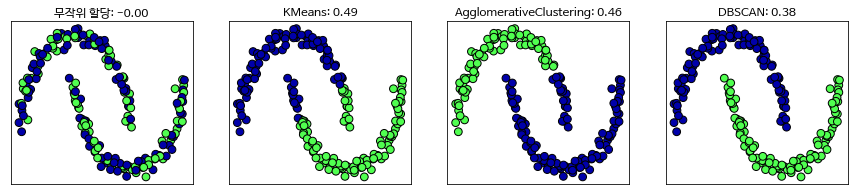

In [2]:
from sklearn.metrics.cluster import silhouette_score

fig, axes = plt.subplots(1, 4, figsize=(15,3), subplot_kw={'xticks':[], 'yticks':[]})
axes[0].scatter(X_scaled[:,0], X_scaled[:,1], c= rand_clusters, cmap=mglearn.cm3, s=60, edgecolors='k')
axes[0].set_title(f'무작위 할당: {silhouette_score(X_scaled, rand_clusters):.2f}')

for ax, model in zip(axes[1:], models):
    clusters = model.fit_predict(X_scaled)
    ax.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters, cmap=mglearn.cm3, s=60, edgecolors='k')
    ax.set_title(f'{model.__class__.__name__}: {silhouette_score(X_scaled, clusters):.2f}')

=> 보다싶이 큰 의미있는 지표는 아닌듯 ㅋ

# 얼굴 데이터에서의 군집 모델 비교

In [3]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]/255
y_people = people.target[mask]

from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_people)

## DBSCAN

### 이상치 검출

In [4]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)

for cluster, count in zip(*np.unique(labels, return_counts=True)):
    print(f'{cluster} : {count}개')

-1 : 32개
0 : 2031개


=> 노이즈가 32개

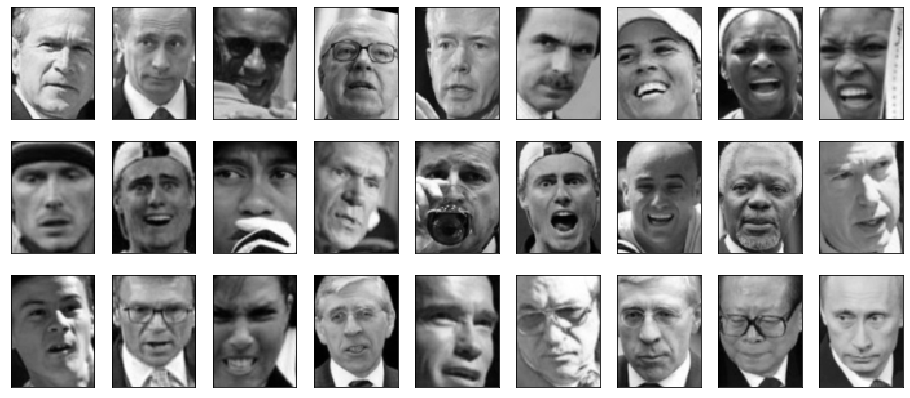

In [5]:
noise = X_people[labels==-1]

fig, axes = plt.subplots(3, 9, subplot_kw={'xticks':[], 'yticks':[]}, figsize=(16,7))
for image, ax in zip(noise, axes.flat):
    ax.imshow(image.reshape(image_shape), cmap='gray', vmin=0, vmax=1)

=> 모자를 쓰고 있거나, 각도가 이상하거나 등

### eps값에 따른 클러스터

In [6]:
for eps in range(1,14,2):
    print('\neps=', eps)
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print('클러스터 수:', len(np.unique(labels)))
    print('클러스터 크기:', np.bincount(labels+1))


eps= 1
클러스터 수: 1
클러스터 크기: [2063]

eps= 3
클러스터 수: 1
클러스터 크기: [2063]

eps= 5
클러스터 수: 1
클러스터 크기: [2063]

eps= 7
클러스터 수: 14
클러스터 크기: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps= 9
클러스터 수: 4
클러스터 크기: [1307  750    3    3]

eps= 11
클러스터 수: 2
클러스터 크기: [ 413 1650]

eps= 13
클러스터 수: 2
클러스터 크기: [ 120 1943]


### eps=7일때의 클러스터

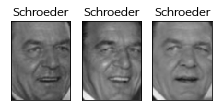

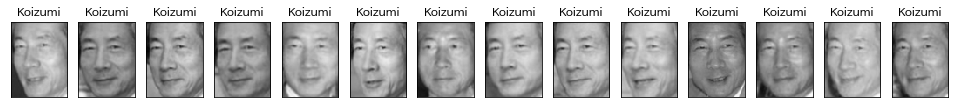

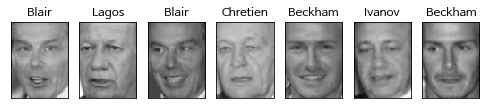

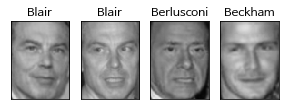

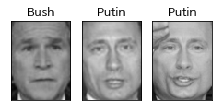

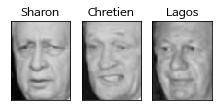

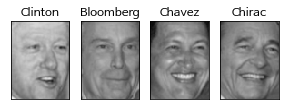

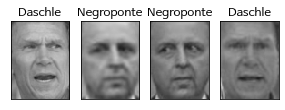

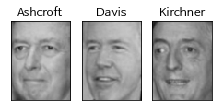

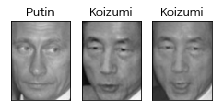

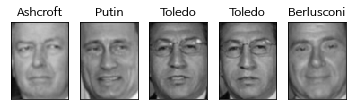

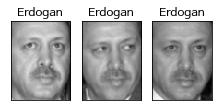

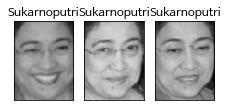

In [7]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels)+1):
    mask = (labels == cluster)
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images*1.2, 3), subplot_kw={'xticks':[], 'yticks':[]})
    
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

## KMeans

### cluster_centers_ 확인

KMeans의 클러스터 크기: [282 226 105 268 151 324 202 208 208  89]


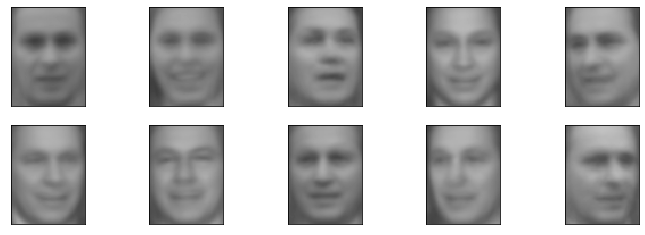

In [8]:
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)

print(f'KMeans의 클러스터 크기:',np.bincount(labels_km))
fig, axes = plt.subplots(2,5, figsize=(12,4), subplot_kw={'xticks':[], 'yticks':[]})
for center, ax in zip(km.cluster_centers_, axes.flat):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), cmap='gray', vmin=0, vmax=1)

### cluster_centers_와 가까운 이미지와 먼 이미지

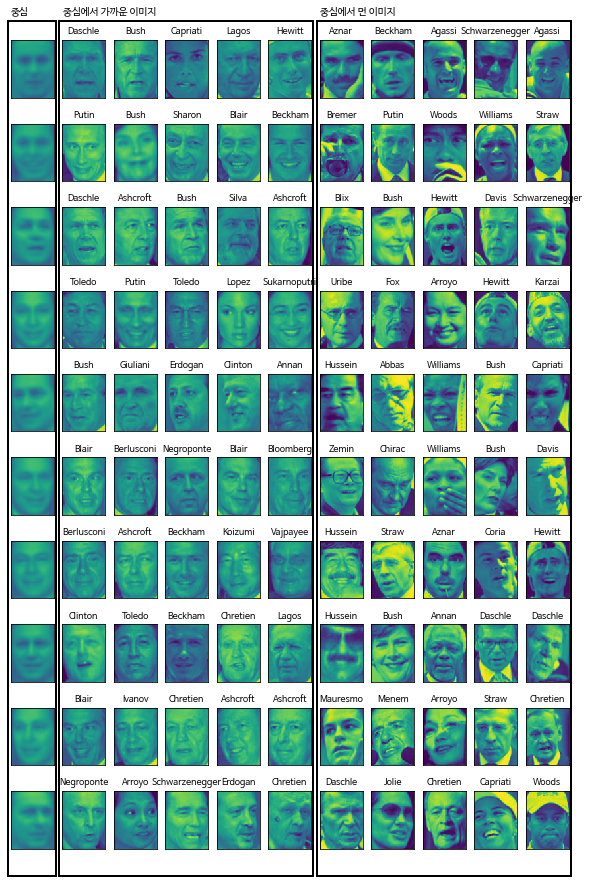

In [9]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people, y_people, people.target_names)

## Agglomerative

### 클러스터 크기 확인

In [10]:
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)

print('병합 군집의 클러스터 크기:', np.bincount(labels_agg))

병합 군집의 클러스터 크기: [169 660 144 329 217  85  18 261  31 149]


### KMeans 군집과의 비교

In [11]:
print(f'ARI: {adjusted_rand_score(labels_agg, labels_km):.2f}')

ARI: 0.10


=> 두 군집 lable_agg와 labels_km에 공통 부분이 거의 없음

### 댄드로그램

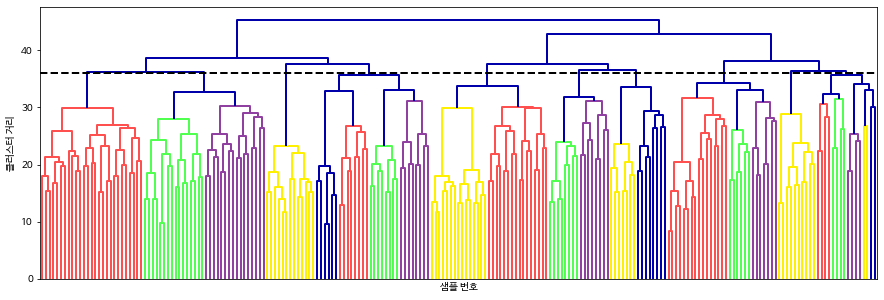

In [12]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(X_pca)
plt.figure(figsize=(15,5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel('샘플 번호')
plt.ylabel('클러스터 거리')
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [36, 36], '--', c='k')

### 클러스터 살펴보기

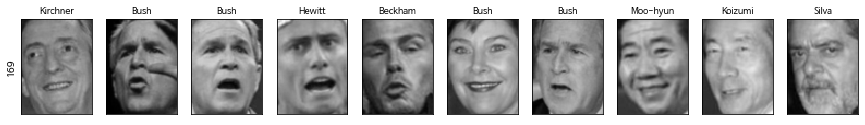

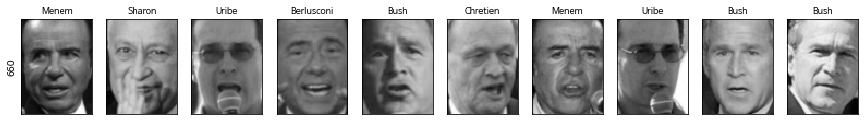

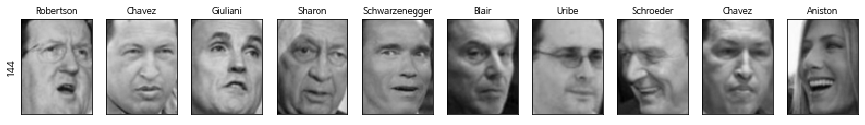

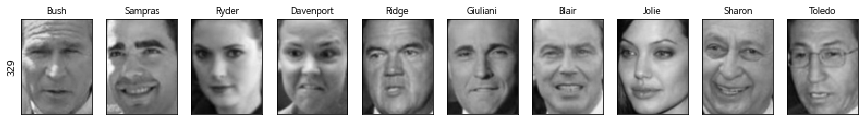

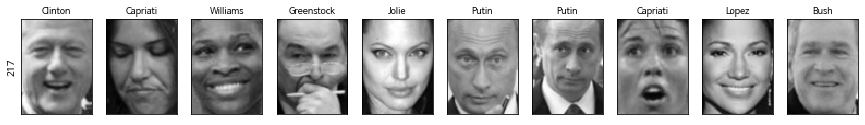

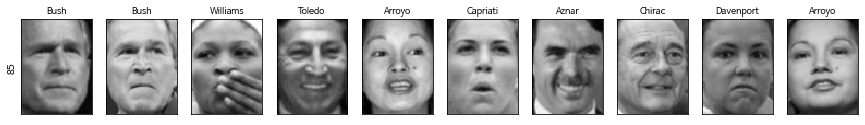

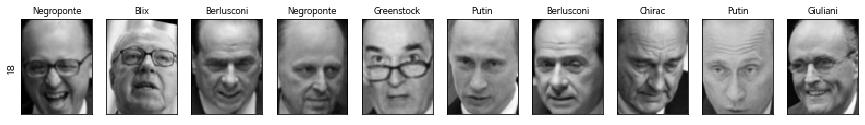

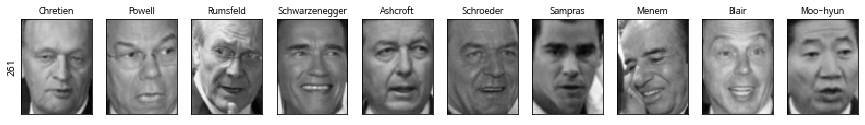

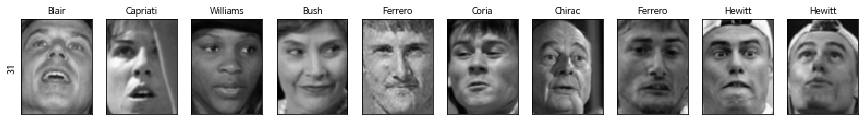

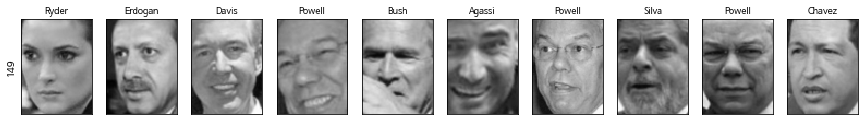

In [13]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = (labels_agg == cluster)
    fig, axes = plt.subplots(1, 10, figsize=(15,8), subplot_kw={'xticks':[], 'yticks':[]})
    axes[0].set_ylabel(np.sum(mask))
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize':9})

=> 딱히 규칙성이 없어보이니 클러스터 수를 늘려보자

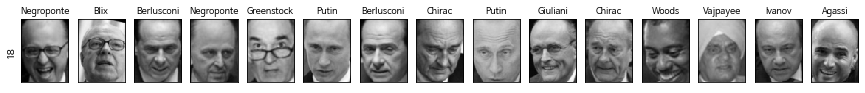

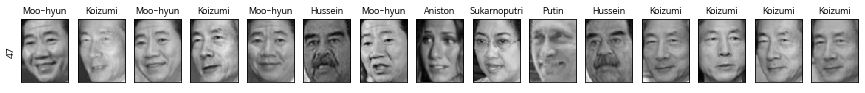

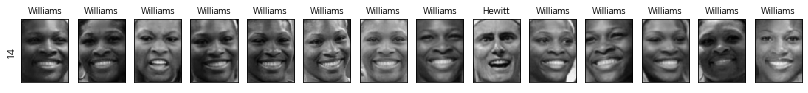

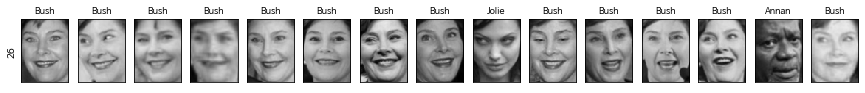

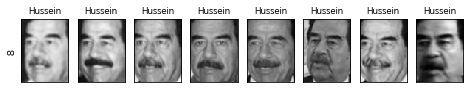

In [14]:
n_clusters = 40
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
labels_agg = agglomerative.fit_predict(X_pca)

for cluster in [13, 16, 23, 38, 39]:  # 흥미로운 클러스터들
    mask = (labels_agg == cluster)
    fig, axes = plt.subplots(1, 15, figsize=(15,8), subplot_kw={'xticks':[], 'yticks':[]})
    cluster_size = np.sum(mask)
    axes[0].set_ylabel(cluster_size)
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize':9})
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)

=> 규칙성이 어느정도 보임 (대머리, 옆모습, 흑인, 여성, 후세인)